### Pool of upwelled water and tracer for 10TR in Astoria and Barkley bathymetries

In [2]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import matplotlib.gridspec as gspec

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [5]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*nz - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomAnom(Tr, hfac, ra, bathy,nz, sbdepth=-152.5):
    '''Tr: Tracer field-Tr field no canyon (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*nz - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                

        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,X,Y,xslice,yslice,colmap, cmin=-1, cmax=1):
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,20,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.5,0.6,0.8,1.0,1.2],colors='k')
    plt.clabel(cs)
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

def PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                xslice_pl, yslice_pl, nz,
                hFacA, rAA, DepthA, XA, YA,
                hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        mesh1 = PlotPool(ax1,ConcLinA/nbl.variables[key][0,30,50,50],XA, YA,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh1, ax=ax1)
    
    with Dataset(ptr_fileB, 'r') as nbl:
        ConcAreaLinB, ConcLinB, AreaTrB = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacB,rAB,DepthB, nz-1,sbdepth=sbdepthB)
        mesh2 = PlotPool(ax2,ConcLinB/nbl.variables[key][0,40,50,50],XB, YB,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh2, ax=ax2)
        
    for ax in [ax1,ax2]:
        ax.set_facecolor("darkgrey")
        ax.set_ylabel('Cross-shelf / km')

    ax1.set_xlabel('CS distance / km')
    ax1.set_title('Astoria')
    ax2.set_xlabel('CS distance / km')
    ax2.set_title('Barkley day %1.1f' %(tt/2))

    ax1.set_aspect(1)
    return(ax1, ax2)

def GetPoolArea(tt, key, ptr_fileA, ptr_fileB,nz,
                hFacA, rAA, DepthA, 
                hFacB, rAB, DepthB, 
                sbdepthA=-150, sbdepthB=-200):
    
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        if key == 'Tr03':
            mask = np.ma.getmask(np.ma.masked_greater((ConcLinA/nbl.variables[key][0,30,50,50]), 1.0))
        else:
            mask = np.ma.getmask(np.ma.masked_less((ConcLinA/nbl.variables[key][0,30,50,50]), 1.0))

        Apool_Ast = np.ma.sum(np.ma.masked_array(AreaTrA, mask=mask))
        
    with Dataset(ptr_fileB, 'r') as nbl:
        ConcAreaLinB, ConcLinB, AreaTrB = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacB,rAB,DepthB, nz-1,sbdepth=sbdepthB)
        if key == 'Tr03':
            mask2 = np.ma.getmask(np.ma.masked_less((ConcLinB/nbl.variables[key][0,40,50,50]), 1.0))
        else:    
            mask2 = np.ma.getmask(np.ma.masked_less((ConcLinB/nbl.variables[key][0,40,50,50]), 1.0))
        Apool_Bar = np.ma.sum(np.ma.masked_array(AreaTrB, mask=mask2))
        
    return(Apool_Ast, Apool_Bar)

def GetPoolConc(tt, key, ptr_fileA, ptr_fileB,nz,
                hFacA, rAA, DepthA, 
                hFacB, rAB, DepthB, 
                sbdepthA=-150, sbdepthB=-200):
    
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        if key == 'Tr03':
            mask = np.ma.getmask(np.ma.masked_greater((ConcLinA/nbl.variables[key][0,30,50,50]), 1.0))
        else:
            mask = np.ma.getmask(np.ma.masked_less((ConcLinA/nbl.variables[key][0,30,50,50]), 1.0))

        ConcPool_Ast = np.ma.mean(np.ma.masked_array(ConcAreaLinA/AreaTrA, mask=mask))
        
    with Dataset(ptr_fileB, 'r') as nbl:
        ConcAreaLinB, ConcLinB, AreaTrB = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacB,rAB,DepthB, nz-1,sbdepth=sbdepthB)
        if key == 'Tr03':
            mask2 = np.ma.getmask(np.ma.masked_less((ConcLinB/nbl.variables[key][0,40,50,50]), 1.0))
        else:    
            mask2 = np.ma.getmask(np.ma.masked_less((ConcLinB/nbl.variables[key][0,40,50,50]), 1.0))
        ConcPool_Bar = np.ma.mean(np.ma.masked_array(ConcAreaLinB/AreaTrB, mask=mask2))
        
    return(ConcPool_Ast, ConcPool_Bar)

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

def plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, 
                                         key, units, zslice, zsliceB, ZA, ZB,
                                         yindA, xindA, yindB, xindB):
    
    fig,ax = plt.subplots(2,3,figsize=(9,6), sharex=True)

    pal1 = sns.color_palette('Greens', 10)
    pal2 = sns.color_palette('Purples', 10)

    for ii in range(3):
        ax[0,ii].axhline(-20, color='0.8')

    for ii in range(3):
        for tt in range(0,19,2):

            tr = getProfile(ptr_fileA, maskCA, key, xindA[ii], yindA[ii], zslice, tt)
            trNoC = getProfile(ptr_fileANoC,maskCANoC, key, xindA[ii], yindA[ii], zslice, tt)
            ax[0,ii].plot(tr-trNoC, ZA[zslice],color=pal1[int(tt/2)], label='%d' %(tt/2))
         
    ax[0,1].set_title('St. 2')
    ax[0,2].set_title('St. 3')
    ax[0,0].set_title('%s Astoria, St. 1' %key)
    ax[0,0].set_ylabel('Depth / m')
    
    for ii in range(3):
        ax[1,ii].axhline(-20, color='0.8')
        ax[1,ii].set_xlabel(r'%s' %units)
    
    for ii in range(3):
        for tt in range(0,19,2):
            tr = getProfile(ptr_fileB, maskCB,key, xindB[ii], yindB[ii], zsliceB, tt)
            trNoC = getProfile(ptr_fileBNoC,maskCBNoC, key, xindB[ii], yindB[ii], zsliceB, tt)
            ax[1,ii].plot(tr-trNoC, ZB[zsliceB],color=pal2[int(tt/2)], label='%d' %(tt/2))
        
    ax[1,1].set_title('St. 2')
    ax[1,2].set_title('St. 3')
    ax[1,0].set_title('%s Barkley, St. 1' %key)
    ax[1,0].set_ylabel('Depth / m')
     
    ax[0,2].legend(bbox_to_anchor=(1,1))   
    ax[1,2].legend(bbox_to_anchor=(1,1))

In [6]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'

In [7]:
nz = 104
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
   

### 01 - Initial profiles

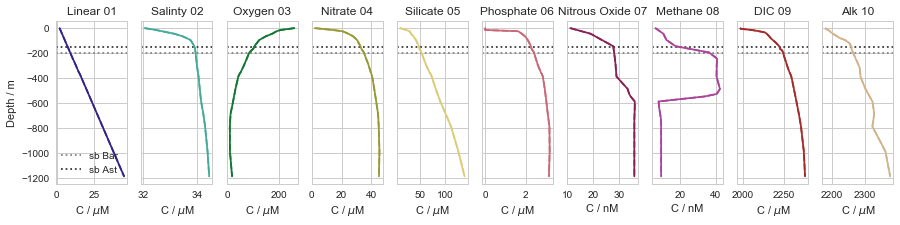

In [8]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'brown', 'tan']
fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]

        ax[ii].plot(tr_profile, Z, color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Initial profiles. Profiles for both runs plotted to check they are actually the same.

#### Vertical tracer gradient

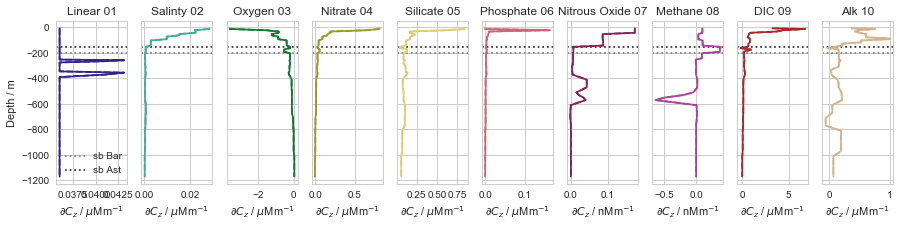

In [9]:
dTr_Ast = np.empty(len(tracers))
dTr_Bar = np.empty(len(tracers))
Tr_Ast = np.empty(len(tracers))
Tr_Bar = np.empty(len(tracers))

fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            dTrdz = (tr_profile[2:]-tr_profile[:-2])/(-Z[2:]+Z[:-2])  
            dTr_Ast[ii] = dTrdz[sb_Ast+1]/dTrdz[sb_Ast-1]
            dTr_Bar[ii] = dTrdz[sb_Bar+1]/dTrdz[sb_Bar-1]
            Tr_Ast[ii] = tr_profile[sb_Ast]
            Tr_Bar[ii] = tr_profile[sb_Bar]
            
        ax[ii].plot(dTrdz, Z[1:-1], color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('$\partial C_z$ / nMm$^{-1}$')
        else:
            ax[ii].set_xlabel(r'$\partial C_z$ / $\mu$Mm$^{-1}$')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

### 02 - Shelf-bottom pool 

Linear tracer (Tr01) 

Tracer gradients below shelf-break depth are the same for both canyons. This is the "base case" pool where both canyons have the same N,f, almost same U, and same dTr/dz at shelf-break depth.

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

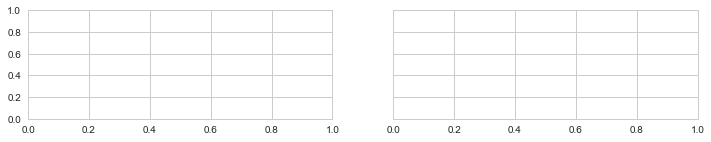

In [10]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr01'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)

yindA = [235,255,250]
xindA = [180,300,400]
yindB = [165, 170, 180]
xindB = [180, 250, 300]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    
             

In [ ]:
key = 'Tr01'
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Salinity (Tr02)

In [ ]:
key = 'Tr02'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250]
xindA = [180,300,400]
yindB = [165, 170, 180]
xindB = [180, 250, 300]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

In [ ]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'PSU'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Oxygen (Tr03)

In [ ]:
key = 'Tr03'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250]
xindA = [180,300,400]
yindB = [165, 170, 180]
xindB = [180, 250, 300]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

In [ ]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Nitrate (Tr04)

In [ ]:
key = 'Tr04'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250]
xindA = [180,300,400]
yindB = [165, 170, 180]
xindB = [180, 250, 300]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

In [ ]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Silicate (Tr05)

In [ ]:
key = 'Tr05'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250]
xindA = [180,300,400]
yindB = [165, 170, 180]
xindB = [180, 250, 300]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

In [ ]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Phosphate (Tr06)

In [ ]:
key = 'Tr06'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250]
xindA = [180,300,400]
yindB = [165, 170, 180]
xindB = [180, 250, 300]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

In [ ]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Nitrous Oxide (Tr07)

In [ ]:
key = 'Tr07'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250]
xindA = [180,300,400]
yindB = [165, 170, 180]
xindB = [180, 250, 300]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

In [ ]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$n$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Methane (Tr08)

In [ ]:
key = 'Tr08'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250]
xindA = [180,300,400]
yindB = [165, 170, 180]
xindB = [180, 250, 300]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

In [ ]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$n$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

In [ ]:
key = 'Tr09'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250]
xindA = [180,300,400]
yindB = [165, 170, 180]
xindB = [180, 250, 300]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

In [ ]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

In [ ]:
key = 'Tr10'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250]
xindA = [180,300,400]
yindB = [165, 170, 180]
xindB = [180, 250, 300]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

In [ ]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Which one is larger?

Which one has higher concentration on average?

Depth of largest gradients vs shelf?

What matters is the tracer gradient below shelf break depth, but how deep is "below"? at shelf-break depth, Z (depth of upwelling), other scale?

Does gradient above matter?

Maybe I should also run a Barkley with same sb depth as Astoria or the opposite...

### HCW and tracer mass from all tracers

- HCW all calculated with lin tracer, but shouldn't it be the same for all tracers ideally?
- TrMass calculated using lin tracer to find cells with upwelled water and concetration from the tracer we are studying.

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

tracers2 = ['Tr01','Tr02','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels2 = ['Linear 01','Salinty 02','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07',
           'Methane 08','DIC 09', 'Alk 10']
colours2 = ['#332288','#44AA99','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'brown', 'tan']

for key, col, lab in zip(tracers2, colours2, labels2):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    HCW_Ast = df_Ast['HCW']
    ax[0].plot(np.arange(19)/2, HCW_Ast, color=col, label=lab)
    
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    df_Bar = pd.read_csv(f_Bar)
    HCW_Bar = df_Bar['HCW']
    ax[1].plot(np.arange(19)/2, HCW_Bar, color=col, label=lab)

ax[0].set_ylabel('HCW / m$^3$')
ax[0].set_xlabel('day')
ax[1].set_xlabel('day')

ax[1].legend(loc=0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,4), sharey=True)

for key, col, lab in zip(tracers2, colours2, labels):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/HCW_TrMass_%s_UPW_10TR_BF2_AST_01.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    TrMass_Ast = df_Ast['TrMassHCW']
    
    if (key == 'Tr07') or (key == 'Tr08'):
        ax[0].plot(np.arange(19)/2, TrMass_Ast*1E-3, color=col, label=lab)
    else:
        ax[0].plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
   
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/HCW_TrMass_%s_UPW_10TR_BF4_BAR_01.csv' %key)
    df_Bar = pd.read_csv(f_Bar)
    TrMass_Bar = df_Bar['TrMassHCW']
    if (key == 'Tr07') or (key == 'Tr08'):
        ax[1].plot(np.arange(19)/2, TrMass_Bar*1E-3, color=col, label=lab)
    else:
        ax[1].plot(np.arange(19)/2, TrMass_Bar, color=col, label=lab)

ax[0].set_ylabel('TrMass / $\mu$M')
ax[0].set_xlabel('day')
ax[1].set_xlabel('day')
ax[0].set_title('Astoria')
ax[1].set_title('Barkley')

ax[1].legend(loc=0)


Here we are comparing muM but not all moles are the same. We are not making a fair comparison because the concentrations are so different. The change in methane on the shelf is huge compared to initial values but it is measured in nM.

### Pool size

In [ ]:
# This cell is super slow

keys = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
nt = 19
pool_B = np.empty((len(keys),nt))
pool_A = np.empty((len(keys),nt))
ii = 0

for key in keys:
    
    for tt in range(nt):
        pool_A[ii,tt], pool_B[ii,tt] = GetPoolArea(tt, key, ptr_fileA, ptr_fileB,nz, hFacA, rAA, 
                                                   DepthA, hFacB, rAB, DepthB, sbdepthA=-150, sbdepthB=-200)
    ii = ii+1

In [ ]:
A_Ast = 1.8E8 # m^2
A_Bar = 8.7E7 # m^2

sns.set_style('whitegrid')
fig, ax = plt.subplots(1,3,figsize=(14,4))

for lab,col,ii in zip(labels2, colours2, [0,1,3,4,5,6,7,8,9]):
    ax[0].plot(np.arange(nt)/2,pool_A[ii,:], '-', color = col, label = lab)
    ax[1].plot(np.arange(nt)/2,pool_B[ii,:], '-', color = col)
    ax[2].plot(np.arange(nt)/2,pool_A[ii,:]/A_Ast, '-', color = col)
    ax[2].plot(np.arange(nt)/2,pool_B[ii,:]/A_Bar, '--', color = col)

for ii in range(len(ax)):
    ax[ii].set_xlabel('days')

ax[0].set_ylabel('Pool area / m$^{2}$')
ax[2].set_ylabel('Pool area / Canyon area')
ax[0].legend()
ax[0].set_title('Astoria')
ax[1].set_title('Barkley')
ax[2].set_title('- - Barkley, - Astoria')


If you approximate canyons as a triangle, their area would be:
   
   $A_{Ast} \approx$ 22 km $\times$ 16 km /2 = 1.8$\times10^{8}$ m$^2$
   
   $A_{Bar} \approx$ 6 km $\times$ 13 km /2 = 8.7$\times10^{7}$ m$^2$
   
   

In [ ]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1,figsize=(6,4))

for lab,col,ii in zip(labels2, colours2, [0,1,3,4,5,6,7,8,9]):
    ax.plot(dTr_Ast[ii],np.mean(pool_A[ii,8:])/A_Ast, 'o', color = col, label = lab)
    ax.plot(dTr_Bar[ii],np.mean(pool_B[ii,8:])/A_Bar, '^', color = col, label = lab)
   
ax.set_ylabel('Pool area / Canyon area')
ax.set_xlabel('$\partial C_z$ above SB/ $\partial C_z$ below SB')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Astoria: o, Barkley ^')


### Pool concentration

In [ ]:
# This cell is super slow

keys = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09', 'Tr10']
nt = 19
Cpool_B = np.empty((len(keys),nt))
Cpool_A = np.empty((len(keys),nt))
ii = 0

for key in keys:
    
    for tt in range(nt):
        Cpool_A[ii,tt], Cpool_B[ii,tt] = GetPoolConc(tt, key, ptr_fileA, ptr_fileB,nz, hFacA, rAA, 
                                                     DepthA, hFacB, rAB, DepthB, sbdepthA=-150, sbdepthB=-200)
    ii = ii+1

In [ ]:
A_Ast = 1.8E8 # m^2
A_Bar = 8.7E7 # m^2

sns.set_style('whitegrid')
fig, ax = plt.subplots(1,3,figsize=(14,4))

for lab,col,ii in zip(labels2, colours2, [0,1,3,4,5,6,7,8,9]):
    ax[0].plot(np.arange(nt)/2,Cpool_A[ii,:]/Tr_Ast[ii], '-', color = col, label = lab)
    ax[1].plot(np.arange(nt)/2,Cpool_B[ii,:]/Tr_Bar[ii], '-', color = col)
    ax[2].plot(np.arange(nt)/2,Cpool_A[ii,:]/Tr_Ast[ii], '-', color = col)
    ax[2].plot(np.arange(nt)/2,Cpool_B[ii,:]/Tr_Bar[ii], '--', color = col)

for ii in range(len(ax)):
    ax[ii].set_xlabel('days')

ax[0].set_ylabel(r'Pool C / $\mu$M')
ax[2].set_ylabel(r'Pool C / $C_{sb}$')
ax[0].legend(bbox_to_anchor=(4,1))
ax[0].set_title('Astoria')
ax[1].set_title('Barkley')
ax[2].set_title('- - Barkley, - Astoria')


In [ ]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1,figsize=(6,4))

for lab,col,ii in zip(labels2, colours2, [0,1,3,4,5,6,7,8,9]):
    ax.plot(dTr_Ast[ii],np.mean(Cpool_A[ii,8:]/Tr_Ast[ii]), 'o', color = col, label = lab)
    ax.plot(dTr_Bar[ii],np.mean(Cpool_B[ii,8:]/Tr_Bar[ii]), '^', color = col, label = lab)
   
ax.set_ylabel('Mean pool concentration / $C_{sb}$')
ax.set_xlabel('$\partial C_z$ above SB/ $\partial C_z$ below SB')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Astoria: o, Barkley ^')


*